In [1]:
import tensorflow as tf                       # 텐서플로우 임포트
from tensorflow.keras import models, layers   # 케라스 관련 모듈 임포트
import numpy as np
import matplotlib.pyplot as plt
 
print(tf.__version__)        # 텐서플로우 버전을 확인하도록 한다.
print(tf.keras.__version__)  # 케라스 버전을 확인한다.

2.2.0-rc3
2.3.0-tf


In [2]:
# MNIST 데이터 로딩
mnist = tf.keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print('train_images의 *원래* 데이터의 shape과 dype:', 
      train_images.shape, train_images.dtype)
print('test_images의 *원래* 데이터의 shape과 dype:', 
      test_images.shape, test_images.dtype)

# Normalizing the images to the range of [0., 1.]
train_images = tf.cast(train_images, tf.float32)
test_images  = tf.cast(test_images, tf.float32)
train_images /= 255
test_images  /= 255

print('train_images의 *바뀐* 데이터의 shape과 dype:', 
      train_images.shape, train_images.dtype)
print('test_images의 *바뀐* 데이터의 shape과 dype:', 
      test_images.shape, test_images.dtype)


# Print out for checking
print(train_images[0].shape)
print(train_images[0][0][0].dtype)
print(train_labels.dtype)

11493376/11490434 [==============================] - 0s 0us/step
train_images의 *원래* 데이터의 shape과 dype: (60000, 28, 28) uint8
test_images의 *원래* 데이터의 shape과 dype: (10000, 28, 28) uint8
train_images의 *바뀐* 데이터의 shape과 dype: (60000, 28, 28) <dtype: 'float32'>
test_images의 *바뀐* 데이터의 shape과 dype: (10000, 28, 28) <dtype: 'float32'>
(28, 28)
<dtype: 'float32'>
uint8


In [3]:
num_classes = 10

train_label_onehots = tf.keras.utils.to_categorical(train_labels, num_classes)  # keras 함수를 이용하여 훈련 레이블을 원핫 인코딩
test_label_onehots  = tf.keras.utils.to_categorical(test_labels, num_classes)  # keras 함수를 이용하여 테스트 레이블을 원핫 인코딩

# 데이터 변환 확인
print(train_label_onehots.shape)
print(test_label_onehots.shape)

print(train_label_onehots[0])
print(train_labels[0])
print(test_label_onehots[0])
print(test_labels[0])

(60000, 10)
(10000, 10)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
5
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
7



## 네트워크에 조건 주입하기

* 조건부 오토인코더를 구현하기 위해서는 네트워크에 손글씨 이미지 뿐만 아니라

  해당하는 이미지가 어떤 숫자를 나타내는지(조건) 또한 주입해야 한다.

* Conv2D 레이어는 N x N 크기의 필터를 이동시켜가며 손글씨 이미지의 정보를 추출하는데,

  이때 필터가 조건을 함께 학습해야 한다.

* 즉, 손글씨 이미지의 각 픽셀 정보와 조건 정보를 합쳐야 한다.

* keras.utils의 to_categorical 함수는 1-d 텐서의 형태로 훈련 레이블을 원핫 인코딩하는데,

  Conv2D 레이어를 사용할 것이므로 손글씨 이미지에 맞게 2-d 텐서 형태로 원핫 인코딩을 해야 한다.
  
* 따라서 one_hot_2d 라는 함수를 정의하여 사용하였다.

* one_hot_2d 함수는 train_labels를 인자로 받아 (60000, 10, 28, 28)의 shape으로 원핫 인코딩 된 조건을 생성한다.
  + 60000은 전체 훈련 레이블(이미지)의 개수, 10은 원핫 인코딩된 2-d 텐서의 배치(0~9), 
  
    (28, 28)은 손글씨 이미지와 같은 크기

In [0]:
def one_hot_2d(label):
  num = label.shape[0]
  cons = np.zeros((num, num_classes, 28, 28))
  for i in range(num):
    k = label[i]
    cons[i][k] = 1

  return cons

In [0]:
train_images_3d = np.reshape(train_images, (60000,1,28,28))  # 원핫 인코딩 된 조건 2-d 텐서와 concatenate 하기 위해 배치 차원 추가
cons_2d = one_hot_2d(train_labels)  # 조건을 2-d 텐서로 원핫 인코딩

In [7]:
print(train_images_3d.shape)
print(cons_2d.shape)

(60000, 1, 28, 28)
(60000, 10, 28, 28)


## 네트워크 모델 설계
* 인코더 모델: 케라스 시퀀셜 모델로 설계
  + InputLayer로 (1,28,28) 영상과 (10,28,28) 조건을 받고, 출력으로 n_dim차원 벡터가 나오도록 함.
* 디코더 모델: 케라스 시퀀셜 모델로 설계
  + InputLayer에서 n_dim차원 벡터를 받고, 출력으로 (28,28) 영상이 나오도록 함.
* 오토인코더 모델: 인코더, 디코더를 결합하여 설계
  + 주의: InputLayer를 추가해야 곧장 함수로서 활용할 수 있음.


우선 n_dim을  2로 설정한다.
* 즉, n_dim=2

In [0]:
n_dim = 2

In [0]:
img = tf.keras.Input(shape=(1,28,28))  # 데이터셋에서 load한 훈련 이미지에 배치 차원을 더한 것
con_2d = tf.keras.Input(shape=(10,28,28))  # 2-d 텐서로 원핫 인코딩된 조건

enc_reshape_1 = tf.keras.layers.Reshape(target_shape=(28,28,11))  # channel last로 작동하는 Conv2D 레이어에 맞춰주기 위함
enc_conv_1 = tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides=2, padding='same', activation='relu')  # 이미지의 크기가 가로 세로 모두 절반이 됨
enc_conv_2 = tf.keras.layers.Conv2D(64, kernel_size=(3,3), strides=2, padding='same', activation='relu')  # 이미지의 크기가 가로 세로 모두 절반이 됨
enc_flatten_1 = tf.keras.layers.Flatten()
enc_dense = tf.keras.layers.Dense(n_dim)

x = tf.keras.layers.concatenate([img, con_2d], axis=1)  # 훈련 이미지와 조건을 배치 채널을 따라 합침 > (60000, 11, 28, 28)
x = enc_reshape_1(x)  # 입력 데이터 (11,28,28)을 channel last로 변경
x = enc_conv_1(x)
x = enc_conv_2(x)
x = enc_flatten_1(x)

z = enc_dense(x)

* 디코더의 input은 n_dim 차원을 가지는 1-d 텐서이므로 조건 정보도 1-d 텐서여야 한다.

* 따라서, 앞서 만든 2-d 형태의 원핫 인코딩된 조건이 아닌 keras.utils의 to_categorical 함수를 통해 만든 1-d 형태의 원핫 인코딩 조건을 사용한다.

In [0]:
con = tf.keras.Input(shape=(10,))  # 잠재 벡터 z는 1-d 텐서이므로 조건도 원핫 인코딩된 1-d 텐서를 사용

dec_dense_1 = tf.keras.layers.Dense(3136, activation='relu')
dec_reshape_1 = tf.keras.layers.Reshape(target_shape=(7,7,64))
dec_inverse_conv2d_1 = tf.keras.layers.Conv2DTranspose(32, kernel_size=(3,3), strides=2, padding='same', activation='relu')  # 이미지의 크기가 가로 세로 모두 두배가 됨
dec_inverse_conv2d_2 = tf.keras.layers.Conv2DTranspose(1, kernel_size=(3,3), strides=2, padding='same', activation='sigmoid')  # 출력은 조건이 없는 흑백(채널=1) 이미지
dec_reshape_2 = tf.keras.layers.Reshape(target_shape=(28,28))  # 시각화를 위해 흑백 채널 삭제

x = tf.keras.layers.concatenate([z, con])  # 인코더를 거쳐 나온 z와 조건을 합침
x = dec_dense_1(x)
x = dec_reshape_1(x)
x = dec_inverse_conv2d_1(x)
x = dec_inverse_conv2d_2(x)

y_pred = dec_reshape_2(x)

## 네트워크 모델 구조 확인
* summary() 함수로 모델의 구조를 텍스트로 프린트할 수 있음.
* plot_model() 함수로 모델의 구조를 텍스트로 프린트할 수 있음.

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1, 28, 28)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10, 28, 28)] 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 11, 28, 28)   0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 28, 28, 11)   0           concatenate[0][0]            

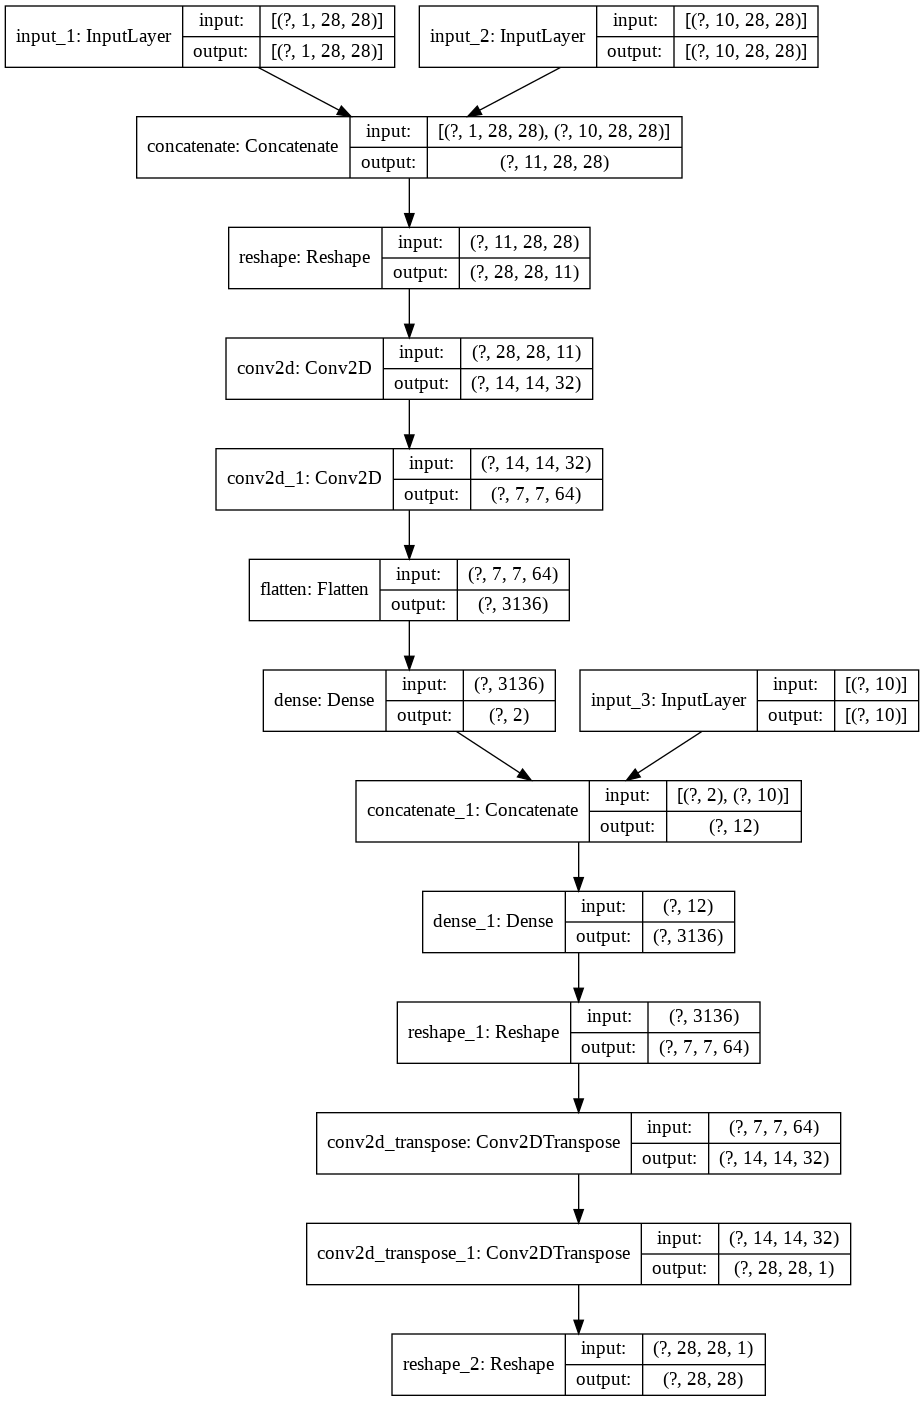

In [13]:
ae = tf.keras.Model(inputs=[img, con_2d, con], outputs=y_pred)

ae.summary()
tf.keras.utils.plot_model(ae, 'ae.png', show_shapes=True)

앞서 언급했듯 인코더의 input에는 (10,28,28)의 조건(input_2)이, 디코더의 input에는 (10, )의 조건(input_3)이 들어감을 확인할 수 있다.



## 오토인코더 인스턴스 트레이닝

AutoEncoder 인스턴스 ae에 대한 훈련 수행
* 인스턴스 ae를 [compile](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile)
  + 이때, 훈련에 활용될 [optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers), [loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses), [metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) 등을 지정함
* 네트워크에 필요한 input을 list로 함께 전달 


In [0]:
ae.compile(optimizer='adam',
           loss='mse',
           metrics=['mae'])

In [15]:
epochs = 20
batch_size = 100

ae.fit([train_images_3d, cons_2d, train_label_onehots], train_images, epochs=epochs, batch_size=batch_size)

Epoch 1/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0629 - mae: 0.1404
Epoch 2/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0442 - mae: 0.1051
Epoch 3/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0384 - mae: 0.0922
Epoch 4/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0367 - mae: 0.0886
Epoch 5/20
600/600 [==============================] - 3s 6ms/step - loss: 0.0359 - mae: 0.0868
Epoch 6/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0353 - mae: 0.0857
Epoch 7/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0349 - mae: 0.0850
Epoch 8/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0346 - mae: 0.0843
Epoch 9/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0344 - mae: 0.0839
Epoch 10/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0341 - mae: 0.0834
Epoch 11/20
600/600 [============================

## 트레이닝이 끝난 오토인코더를 이용하기
트레이닝이 끝난 오토인코더는 함수로서 작동이 가능하다. 

* 네트워크에 이미지와 조건들을 주입하고 오토인코더가 원본 이미지를 어떻게 재구성하는지 확인

In [0]:
results = ae([train_images_3d, cons_2d, train_label_onehots])

In [17]:
import ipywidgets as widgets

def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)
  plt.imshow(train_images[idx])
  plt.subplot(122)
  plt.imshow(results[idx])
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

앞서 오토인코더(vanilla)를 학습시켰을 때는 z가 8차원일때 까지도 인덱스 0, 19064 등에서 원본 이미지를 재구성하는 데 어려움이 있었지만, 

조건을 주입하여 학습시키니 z가 2차원만 되도 어려움 없이 원본 이미지를 잘 재구성해내었다.

특히, 중간에 1024개의 unit을 가지는 dense 레이어를 추가하지도 않고 이 정도 성능을 보이는 점이 조건부 오토인코더의 강점인 것 같다.

## z의 분포 확인

* 조건을 주어 오토인코더를 학습시키면 네트워크가 조건 별로 임베딩 공간을 가지는 효과가 있기 때문에,

  일반적인 오토인코더에 비해 representation z가 같은 위치에 임베딩 될 가능성이 높다

In [19]:
enc = tf.keras.Model(inputs=[img, con_2d], outputs=z)
z = enc([train_images_3d, cons_2d])
print(z.shape)

(60000, 2)


z가 2차원이므로 별도의 처리 없이 시각화가 가능하다.

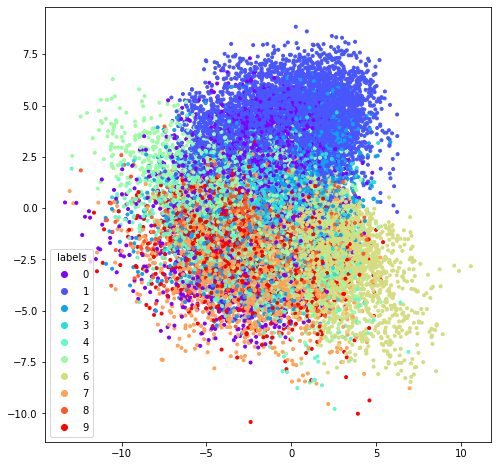

In [20]:
# 잠재 벡터 z를 시각화
plt.figure(figsize=(8,8))
scat = plt.scatter(z[:,0], z[:,1], marker='.', c=train_labels, cmap='rainbow')
plt.legend(*scat.legend_elements(), loc="lower left", title='labels')
plt.show()

실제로 z를 산점도를 통해 그려보니, 각 조건들이 넓은 영역에서 겹쳐 있음을 확인할 수 있다.

위에서 확인했듯 z를 디코더를 통해 재구성했을 때 원본 이미지를 잘 재현했으므로, 

학습이 안된것이 아니라 네트워크가 조건 정보를 충분히 반영하여 입력을 인코딩했음을 알 수 있다.

## 조건별 z의 분포

* 위 산점도에서 서로 다른 색을 부여하여 조건별로 z의 분포를 가시화했는데, 
  이번에는 조건별로 총 10개의 산점도를 따로 그려보았다.

* 이를 위해 조건별로 z를 분리하는 함수(find_label)을 정의하였다.

* 추가적으로, 각 조건별 z의 평균을 구해 수치적으로 각 조건들이 어느 정도로 유사하게 인코딩 되었는지 가늠해보기도 하였다. (find_mean)

In [0]:
# 레이블(0~9)을 입력으로 받고 해당 레이블을 가지는 이미지의 인덱스들을 반환하는 함수
def find_label (label, x):
    r = np.arange(len(label))
    mask = (label == x)
    idx = r[mask]
    return idx

# z와 인덱스 배열을 입력으로 받고 z에서 해당하는 인덱스 열들의 평균을 반환하는 함수 
def find_mean(z, idx):
    mean_label = np.mean(tf.gather(z, idx), axis=0)
    return mean_label

In [22]:
# 각 조건에 대한 평균을 구하여 출력
mean_digits = np.zeros((10,n_dim))
for i in range(10):
  digit = find_label(train_labels, i)
  mean_digits[i][:] = find_mean(z, digit)
  print('label', i, '\'s mean :', mean_digits[i])
  print()

label 0 's mean : [-1.39224672  0.899436  ]

label 1 's mean : [-0.27558681  3.83938766]

label 2 's mean : [-0.83219802  0.28742585]

label 3 's mean : [-0.80035567  0.38800174]

label 4 's mean : [-1.94655454 -0.6154905 ]

label 5 's mean : [-1.74902129  0.04802122]

label 6 's mean : [ 1.42689562 -1.2493664 ]

label 7 's mean : [-1.84043205 -1.4729563 ]

label 8 's mean : [-1.57931292 -0.54322922]

label 9 's mean : [-1.80881095 -1.04008043]



실제로 각 레이블들의 두 차원이 [-1, 0]을 중심으로 인코딩 되었음을 확인할 수 있다.

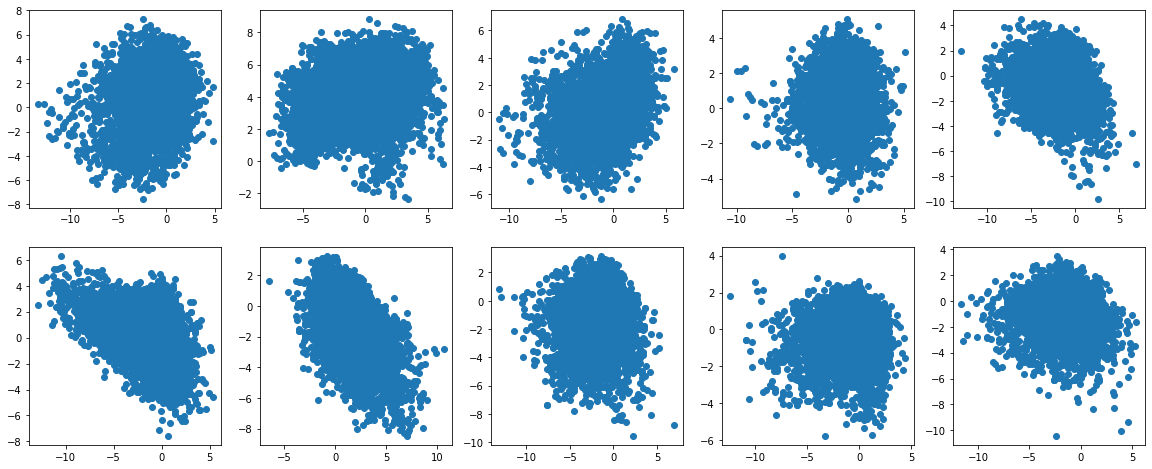

In [23]:
# 각 조건별로 분포 시각화
plt.figure(figsize=(20,8))
for i in range(10):
  digit = find_label(train_labels, i)
  arr = tf.gather(z, digit)
  plt.subplot(2,5,i+1)
  plt.scatter(arr[:,0], arr[:,1])

각 조건별로 분포를 보면 대부분 같은 범위의 x(첫번째 차원)축과 y(두번째 차원)축을 가짐을 확인할 수 있다.

추가적으로 위에서 두 차원이 [-1, 0] 부근을 중심으로 퍼져있다고 보았는데,

실제로 10개 조건 모두 x축과 y축에 각각 -1과 0을 포함하고 있다.

# z의 차원 변경

앞선 오토인코더에서도 그랬고 대부분 z의 차원을 크게 가져가면 그만큼 더 많은 정보를 담을 수 있어 학습이 더 잘되는 경향이 있다.

 따라서 z를 4차원으로 키워 학습시켜보았다.

  * 인코더와 디코더 구조, 기타 하이퍼파라미터 등은 그대로 사용

In [0]:
n_dim = 4

In [0]:
img = tf.keras.Input(shape=(1,28,28))  # 데이터셋에서 load한 훈련 이미지에 배치 차원을 더한 것
con_2d = tf.keras.Input(shape=(10,28,28))  # 2-d 텐서로 원핫 인코딩된 조건

enc_reshape_1 = tf.keras.layers.Reshape(target_shape=(28,28,11))  # channel last로 작동하는 Conv2D 레이어에 맞춰주기 위함
enc_conv_1 = tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides=2, padding='same', activation='relu')  # 이미지의 크기가 가로 세로 모두 절반이 됨
enc_conv_2 = tf.keras.layers.Conv2D(64, kernel_size=(3,3), strides=2, padding='same', activation='relu')  # 이미지의 크기가 가로 세로 모두 절반이 됨
enc_flatten_1 = tf.keras.layers.Flatten()
enc_dense = tf.keras.layers.Dense(n_dim)

x = tf.keras.layers.concatenate([img, con_2d], axis=1)  # 훈련 이미지와 조건을 배치 채널을 따라 합침 > (60000, 11, 28, 28)
x = enc_reshape_1(x)  # 입력 데이터 (11,28,28)을 channel last로 변경
x = enc_conv_1(x)
x = enc_conv_2(x)
x = enc_flatten_1(x)

z = enc_dense(x)

con = tf.keras.Input(shape=(10,))  # 잠재 벡터 z는 1-d 텐서이므로 조건도 원핫 인코딩된 1-d 텐서를 사용

dec_dense_1 = tf.keras.layers.Dense(3136, activation='relu')
dec_reshape_1 = tf.keras.layers.Reshape(target_shape=(7,7,64))
dec_inverse_conv2d_1 = tf.keras.layers.Conv2DTranspose(32, kernel_size=(3,3), strides=2, padding='same', activation='relu')  # 이미지의 크기가 가로 세로 모두 두배가 됨
dec_inverse_conv2d_2 = tf.keras.layers.Conv2DTranspose(1, kernel_size=(3,3), strides=2, padding='same', activation='sigmoid')  # 출력은 조건이 없는 흑백(채널=1) 이미지
dec_reshape_2 = tf.keras.layers.Reshape(target_shape=(28,28))  # 시각화를 위해 흑백 채널 삭제

x = tf.keras.layers.concatenate([z, con])  # 인코더를 거쳐 나온 z와 조건을 합침
x = dec_dense_1(x)
x = dec_reshape_1(x)
x = dec_inverse_conv2d_1(x)
x = dec_inverse_conv2d_2(x)

y_pred = dec_reshape_2(x)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1, 28, 28)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10, 28, 28)] 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 11, 28, 28)   0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 28, 28, 11)   0           concatenate[0][0]            

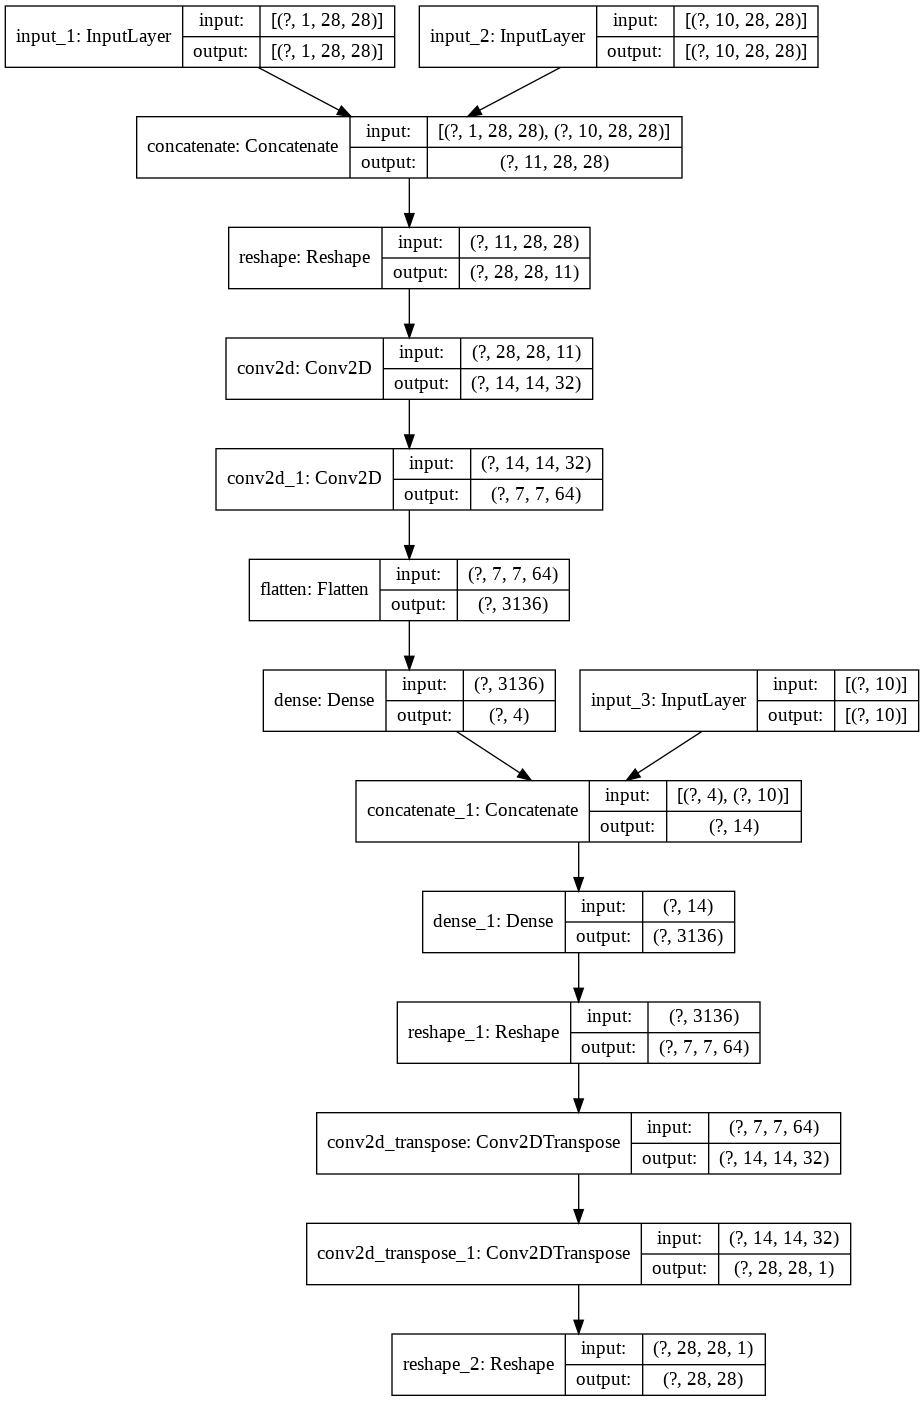

In [10]:
ae = tf.keras.Model(inputs=[img, con_2d, con], outputs=y_pred)

ae.summary()
tf.keras.utils.plot_model(ae, 'ae.png', show_shapes=True)

### n_dim이 2차원일때와 같은 조건으로 오토인코더를 컴파일하고 학습

In [0]:
ae.compile(optimizer='adam',
           loss='mse',
           metrics=['mae'])

In [13]:
epochs = 20
batch_size = 100

ae.fit([train_images_3d, cons_2d, train_label_onehots], train_images, epochs=epochs, batch_size=batch_size)

Epoch 1/20
600/600 [==============================] - 35s 59ms/step - loss: 0.0593 - mae: 0.1328
Epoch 2/20
600/600 [==============================] - 35s 59ms/step - loss: 0.0368 - mae: 0.0899
Epoch 3/20
600/600 [==============================] - 36s 60ms/step - loss: 0.0327 - mae: 0.0813
Epoch 4/20
600/600 [==============================] - 35s 59ms/step - loss: 0.0305 - mae: 0.0766
Epoch 5/20
600/600 [==============================] - 35s 59ms/step - loss: 0.0292 - mae: 0.0737
Epoch 6/20
600/600 [==============================] - 35s 59ms/step - loss: 0.0284 - mae: 0.0719
Epoch 7/20
600/600 [==============================] - 35s 59ms/step - loss: 0.0278 - mae: 0.0705
Epoch 8/20
600/600 [==============================] - 35s 59ms/step - loss: 0.0273 - mae: 0.0695
Epoch 9/20
600/600 [==============================] - 36s 60ms/step - loss: 0.0269 - mae: 0.0688
Epoch 10/20
600/600 [==============================] - 36s 59ms/step - loss: 0.0266 - mae: 0.0681
Epoch 11/20
600/600 [========

## 트레이닝이 끝난 오토인코더를 이용하기
트레이닝이 끝난 오토인코더는 함수로서 작동이 가능하다. 

* 네트워크에 이미지와 조건들을 주입하고 오토인코더가 원본 이미지를 어떻게 재구성하는지 확인

In [0]:
results = ae([train_images_3d, cons_2d, train_label_onehots])

In [14]:
import ipywidgets as widgets

def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)
  plt.imshow(train_images[idx])
  plt.subplot(122)
  plt.imshow(results[idx])
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

z가 2차원일 때도 학습이 잘 되서 큰 차이는 없었지만

 4차원으로 키우니 이전보다 더 선명하게 원본 이미지를 재구성해냈다.

## z의 분포 확인

* 이제 z가 4차원이기 때문에 바로 시각화하기는 어렵다.

* 따라서, TSNE를 통해 2차원으로 축소한 후 시각화를 진행하였다.

In [15]:
enc = tf.keras.Model(inputs=[img, con_2d], outputs=z)
z = enc([train_images_3d, cons_2d])
print(z.shape)

(60000, 4)


In [16]:
%%time
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, method='barnes_hut', random_state=42)
z_reduced = tsne.fit_transform(z)
print(z_reduced.shape)

(60000, 2)
CPU times: user 22min 58s, sys: 1.91 s, total: 23min
Wall time: 11min 49s


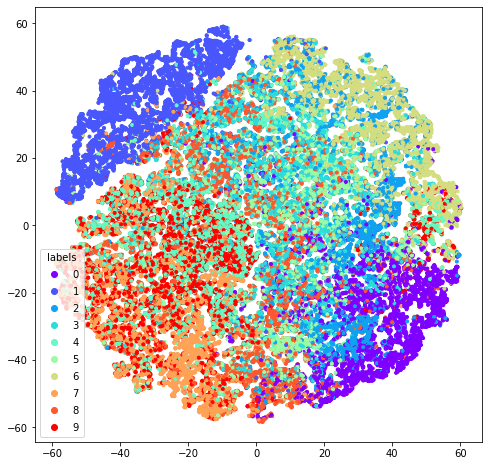

In [17]:
# 잠재 벡터 z를 시각화
plt.figure(figsize=(8,8))
scat = plt.scatter(z_reduced[:,0], z_reduced[:,1], marker='.', c=train_labels, cmap='rainbow')
plt.legend(*scat.legend_elements(), loc="lower left", title='labels')
plt.show()

z를 2차원으로 학습했을 때는 중심은 있지만 자유롭게 흩어져있는 형태였는데,

z를 4차원으로 하니 전체적으로 원의 형태가 생겼고 그 안에서 각 조건들이 혼재해있음을 확인할 수 있다.

추가적으로 '1'을 인코딩한 정보들은 다른 조건들과 분리된 모습을 볼 수 있었다.

## 조건별 z의 분포

* 위 산점도에서 색을 이용하여 조건별로 z의 분포를 가시화했는데, 
  이번에는 조건별로 총 10개의 산점도를 그려보았다.

* 추가적으로, 각 조건별 z의 평균을 구해 수치적으로 각 조건들이 어느 정도로 유사하게 인코딩 되었는지 가늠해보기도 하였다.

In [16]:
# 각 조건에 대한 평균을 구하여 출력
mean_digits = np.zeros((10,n_dim))
for i in range(10):
  digit = find_label(train_labels, i)
  mean_digits[i][:] = find_mean(z, digit)
  print('label', i, '\'s mean :', mean_digits[i])
  print()

label 0 's mean : [ 3.54619527 -3.8061893   0.78685457  1.56239712]

label 1 's mean : [5.62606382 6.97293377 3.6434269  1.21009707]

label 2 's mean : [ 1.57889664  0.18113604  2.14196563 -1.70105326]

label 3 's mean : [ 3.22823167  0.76147681 -0.43361622 -1.30663228]

label 4 's mean : [ 1.1045332   1.88490438 -1.69073462  3.59807992]

label 5 's mean : [ 3.87105584 -0.88801032  0.95582962  1.74993134]

label 6 's mean : [-1.30377591  0.39626062  3.36616945  3.47461891]

label 7 's mean : [ 2.52179742  2.27003384 -2.11326885  2.42391253]

label 8 's mean : [4.61946297 0.34594682 0.17384776 1.20747519]

label 9 's mean : [ 1.92216241  1.93001056 -2.236763    3.69363737]



각 조건별로 평균을 구해보니 이번에도 차원별로 비슷한 값을 평균으로 가지는 양상을 보여주었다.

그러나 2차원일때보다는 편차가 조금 커졌다.

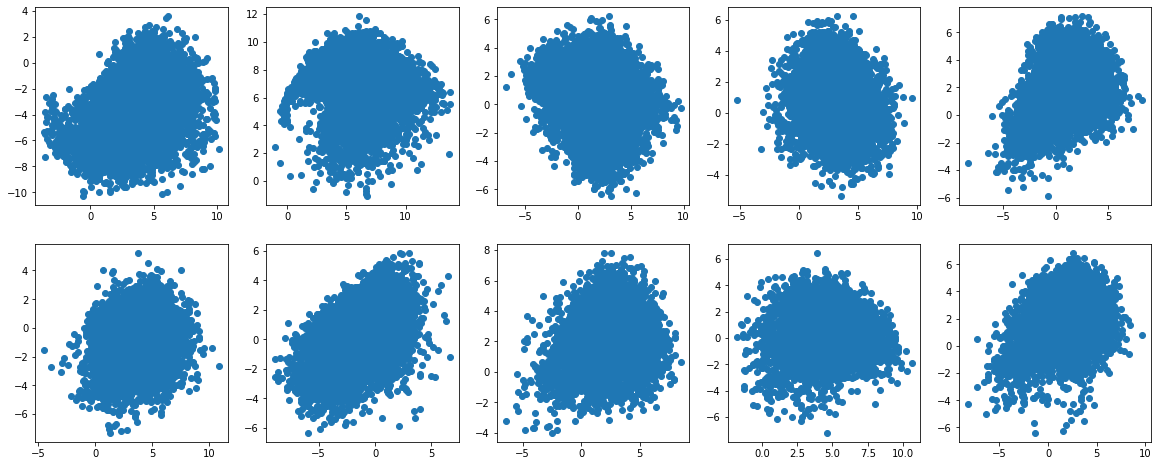

In [17]:
# 각 조건별로 분포 시각화
plt.figure(figsize=(20,8))
for i in range(10):
  digit = find_label(train_labels, i)
  arr = tf.gather(z_reduced, digit)
  plt.subplot(2,5,i+1)
  plt.scatter(arr[:,0], arr[:,1])

각 조건별로 분포를 그려보니 여전히 비슷한 범위의 x축(첫 번째 차원)과 y축(두 번째 차원)을 가지고 있음을 알 수 있다.

# z의 차원 변경

z가 2차원, 4차원에서 충분히 좋은 결과를 보여주었지만 8차원으로 한 번 더 차원을 늘려 시도해보았다.

  * 인코더와 디코더 구조, 기타 하이퍼파라미터 등은 그대로 사용

In [0]:
n_dim = 8

In [0]:
img = tf.keras.Input(shape=(1,28,28))  # 데이터셋에서 load한 훈련 이미지에 배치 차원을 더한 것
con_2d = tf.keras.Input(shape=(10,28,28))  # 2-d 텐서로 원핫 인코딩된 조건

enc_reshape_1 = tf.keras.layers.Reshape(target_shape=(28,28,11))  # channel last로 작동하는 Conv2D 레이어에 맞춰주기 위함
enc_conv_1 = tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides=2, padding='same', activation='relu')  # 이미지의 크기가 가로 세로 모두 절반이 됨
enc_conv_2 = tf.keras.layers.Conv2D(64, kernel_size=(3,3), strides=2, padding='same', activation='relu')  # 이미지의 크기가 가로 세로 모두 절반이 됨
enc_flatten_1 = tf.keras.layers.Flatten()
enc_dense = tf.keras.layers.Dense(n_dim)

x = tf.keras.layers.concatenate([img, con_2d], axis=1)  # 훈련 이미지와 조건을 배치 채널을 따라 합침 > (60000, 11, 28, 28)
x = enc_reshape_1(x)  # 입력 데이터 (11,28,28)을 channel last로 변경
x = enc_conv_1(x)
x = enc_conv_2(x)
x = enc_flatten_1(x)

z = enc_dense(x)

con = tf.keras.Input(shape=(10,))  # 잠재 벡터 z는 1-d 텐서이므로 조건도 원핫 인코딩된 1-d 텐서를 사용

dec_dense_1 = tf.keras.layers.Dense(3136, activation='relu')
dec_reshape_1 = tf.keras.layers.Reshape(target_shape=(7,7,64))
dec_inverse_conv2d_1 = tf.keras.layers.Conv2DTranspose(32, kernel_size=(3,3), strides=2, padding='same', activation='relu')  # 이미지의 크기가 가로 세로 모두 두배가 됨
dec_inverse_conv2d_2 = tf.keras.layers.Conv2DTranspose(1, kernel_size=(3,3), strides=2, padding='same', activation='sigmoid')  # 출력은 조건이 없는 흑백(채널=1) 이미지
dec_reshape_2 = tf.keras.layers.Reshape(target_shape=(28,28))  # 시각화를 위해 흑백 채널 삭제

x = tf.keras.layers.concatenate([z, con])  # 인코더를 거쳐 나온 z와 조건을 합침
x = dec_dense_1(x)
x = dec_reshape_1(x)
x = dec_inverse_conv2d_1(x)
x = dec_inverse_conv2d_2(x)

y_pred = dec_reshape_2(x)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1, 28, 28)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10, 28, 28)] 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 11, 28, 28)   0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 28, 28, 11)   0           concatenate[0][0]            

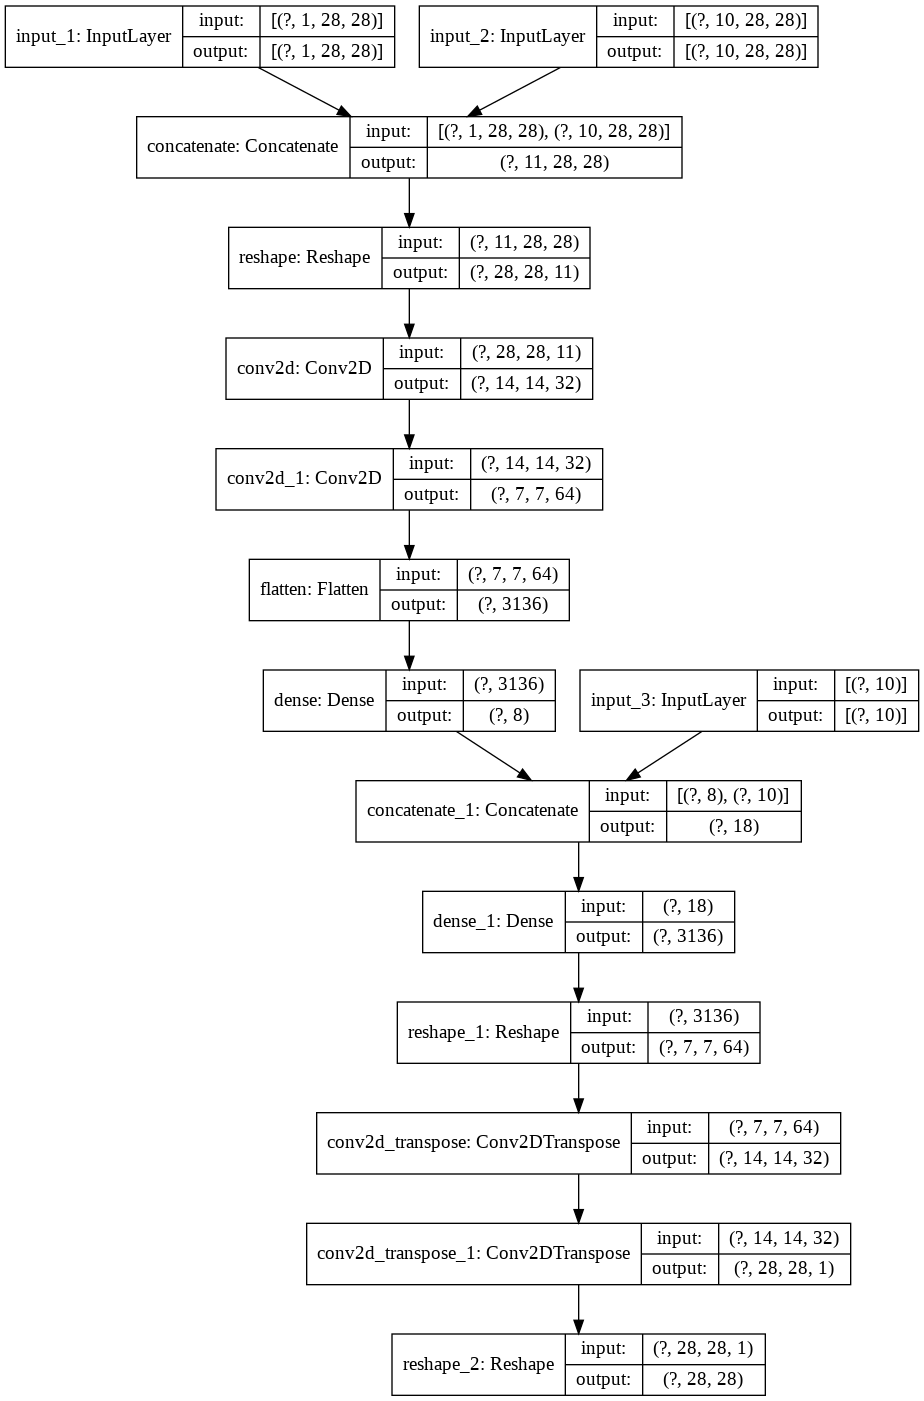

In [9]:
ae = tf.keras.Model(inputs=[img, con_2d, con], outputs=y_pred)

ae.summary()
tf.keras.utils.plot_model(ae, 'ae.png', show_shapes=True)

### n_dim이 2차원, 4차원일때와 같은 조건으로 오토인코더를 컴파일하고 학습

In [0]:
ae.compile(optimizer='adam',
           loss='mse',
           metrics=['mae'])

In [11]:
epochs = 20
batch_size = 100

ae.fit([train_images_3d, cons_2d, train_label_onehots], train_images, epochs=epochs, batch_size=batch_size)

Epoch 1/20
600/600 [==============================] - 3s 4ms/step - loss: 0.0541 - mae: 0.1229
Epoch 2/20
600/600 [==============================] - 3s 4ms/step - loss: 0.0268 - mae: 0.0694
Epoch 3/20
600/600 [==============================] - 3s 4ms/step - loss: 0.0221 - mae: 0.0597
Epoch 4/20
600/600 [==============================] - 3s 4ms/step - loss: 0.0201 - mae: 0.0554
Epoch 5/20
600/600 [==============================] - 3s 4ms/step - loss: 0.0189 - mae: 0.0527
Epoch 6/20
600/600 [==============================] - 3s 4ms/step - loss: 0.0181 - mae: 0.0510
Epoch 7/20
600/600 [==============================] - 3s 4ms/step - loss: 0.0175 - mae: 0.0497
Epoch 8/20
600/600 [==============================] - 3s 4ms/step - loss: 0.0170 - mae: 0.0487
Epoch 9/20
600/600 [==============================] - 3s 4ms/step - loss: 0.0166 - mae: 0.0479
Epoch 10/20
600/600 [==============================] - 3s 4ms/step - loss: 0.0163 - mae: 0.0472
Epoch 11/20
600/600 [============================

## 트레이닝이 끝난 오토인코더를 이용하기
트레이닝이 끝난 오토인코더는 함수로서 작동이 가능하다. 

* 네트워크에 이미지와 조건들을 주입하고 오토인코더가 원본 이미지를 어떻게 재구성하는지 확인

In [0]:
results = ae([train_images_3d, cons_2d, train_label_onehots])

In [13]:
import ipywidgets as widgets

def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)
  plt.imshow(train_images[idx])
  plt.subplot(122)
  plt.imshow(results[idx])
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

z가 4차원일때도 이미 충분히 재구성이 잘 이뤄진 만큼, 

8차원으로 학습시킨 경우에도 원본 이미지를 잘 구성해내었다.

## z의 분포 확인

* z가 8차원이기 때문에 바로 시각화하기는 어렵다.

* 따라서, TSNE를 통해 2차원으로 축소한 후 시각화를 진행하였다.

In [0]:
enc = tf.keras.Model(inputs=[img, con_2d], outputs=z)
z = enc([train_images_3d, cons_2d])
print(z.shape)

In [15]:
%%time
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, method='barnes_hut', random_state=42)
z_reduced = tsne.fit_transform(z)
print(z_reduced.shape)

(60000, 2)
CPU times: user 28min 2s, sys: 1.69 s, total: 28min 4s
Wall time: 7min 19s


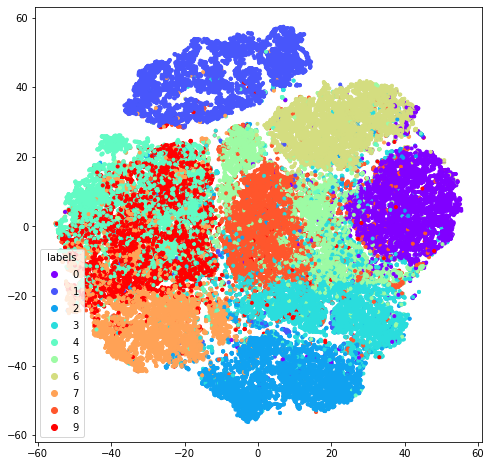

In [16]:
# 잠재 벡터 z를 시각화
plt.figure(figsize=(8,8))
scat = plt.scatter(z_reduced[:,0], z_reduced[:,1], marker='.', c=train_labels, cmap='rainbow')
plt.legend(*scat.legend_elements(), loc="lower left", title='labels')
plt.show()

z를 8차원으로 늘리니 조건들이 서로 분리되는 모습을 볼 수 있었다.

8차원을 그대로 시각화한 것이 아니라 정확하지는 않지만, 담을 수 있는 정보가 많아지면서 서로 구분되는 것 같다.

또한 z가 2차원일때보다 4차원일때 각 조건들의 평균이 더 큰 편차를 보였는데, 

조금씩 커지는 편차가 TSNE를 통해 차원 축소를 할때 서로 더 구분되게 하는 원인이라고 생각한다.

In [17]:
# 각 조건에 대한 평균을 구하여 출력
mean_digits = np.zeros((10,n_dim))
for i in range(10):
  digit = find_label(train_labels, i)
  mean_digits[i][:] = find_mean(z, digit)
  print('label', i, '\'s mean :', mean_digits[i])
  print()

label 0 's mean : [ 2.3832159   1.66349435 -5.05177498 -0.13046862  0.91697782  0.64099908
  2.47347951 -0.83135593]

label 1 's mean : [-1.65548229  2.70742226 -0.88247508  1.49736524  0.23245479  0.68520349
 -3.26030302  3.53585172]

label 2 's mean : [ 0.77849841  3.1025207   0.23875608  3.11587071 -0.50074154 -1.76690662
  2.04581761  1.26845253]

label 3 's mean : [ 1.99195564  2.28107023 -0.56028217  1.01007175  2.9912169   0.58786899
  1.65824854  2.70372987]

label 4 's mean : [-1.33798754 -2.20583415 -0.16122331  2.79908705  3.05312657 -0.13547827
 -0.07239401  1.08824825]

label 5 's mean : [-0.47896767  0.88908672 -2.43259311  0.04406768  3.8988409   1.0875684
  0.84950888  1.09027922]

label 6 's mean : [-0.56754625  1.80813777 -2.41324377 -0.14236723  3.19795513 -2.52633643
 -1.49022162 -1.05699909]

label 7 's mean : [ 1.15088105 -2.66178203 -1.84943688  3.08097887  0.3359364   0.96148109
 -0.81471431  3.40826082]

label 8 's mean : [-1.20170259  0.97466242 -2.96553612  0

실제로 각 조건들의 평균을 구해보니 각 조건들이 8차원 모두에서 비슷한 값을 중심으로 인코딩된 것을 확인할 수 있었다.

산점도를 보고 생각했던 것 보다는 차이가 적긴하지만, 차원 수가 두배이다보니 오차도 그만큼 누적되어 커졌다고 볼 수 있다.

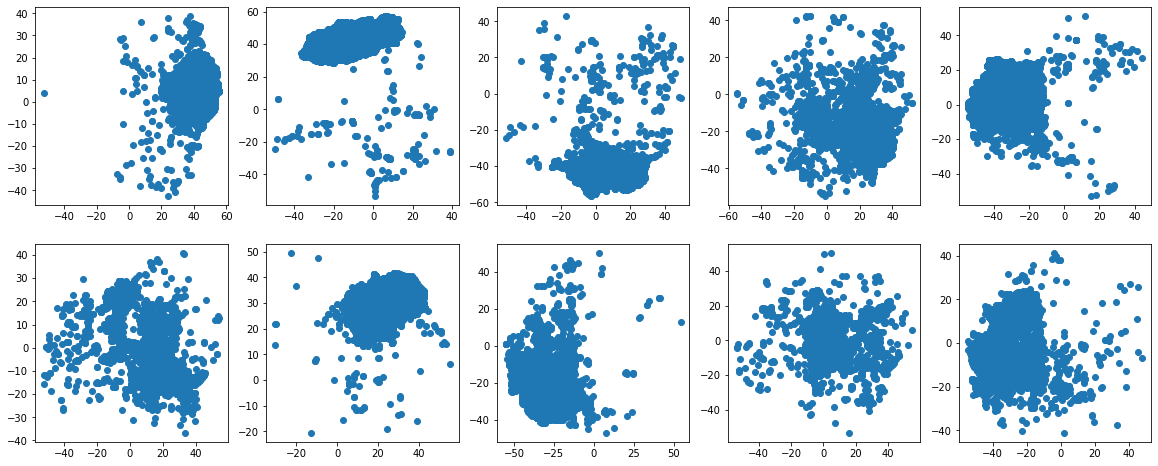

In [19]:
# 각 조건별로 분포 시각화
plt.figure(figsize=(20,8))
for i in range(10):
  digit = find_label(train_labels, i)
  arr = tf.gather(z_reduced, digit)
  plt.subplot(2,5,i+1)
  plt.scatter(arr[:,0], arr[:,1])

각 조건별로 2차원으로 축소된 벡터를 그려보았을 때 확실히 전보다는 조건별로 조금씩 다른 경향을 보여주었다.

### z를 2, 4, 8차원으로 변경해가며 조건부 오토인코더를 학습시켰는데,

### z가 2차원일 때 가장 좋은 결과가 나왔다고 생각한다.

### 4차원일 때도 비슷했지만 전체적인 모양이 원으로 한정되었고

### '1' 조건을 가지는 벡터들이 분리되는 경향을 보였기에 2차원일 때가 조금 더 좋은 결과인 것 같다.

# 디코더를 이용한 Generative Model 구성
## 디코더 부분을 따로 모델로 설정하기
다음과 같은 방법으로 트레이닝이 끝난 조건부 오토인코더의 디코더를 모델로서 활용할 수 있다.
 * z가 2차원일때 가장 좋은 결과가 나왔으므로, n_dim을 2차원으로 하여  다시 오토인코더를 훈련시킨 후 진행


In [0]:
n_dim = 2

In [0]:
img = tf.keras.Input(shape=(1,28,28))  # 데이터셋에서 load한 훈련 이미지에 배치 차원을 더한 것
con_2d = tf.keras.Input(shape=(10,28,28))  # 2-d 텐서로 원핫 인코딩된 조건

enc_reshape_1 = tf.keras.layers.Reshape(target_shape=(28,28,11))  # channel last로 작동하는 Conv2D 레이어에 맞춰주기 위함
enc_conv_1 = tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides=2, padding='same', activation='relu')  # 이미지의 크기가 절반이 됨
enc_conv_2 = tf.keras.layers.Conv2D(64, kernel_size=(3,3), strides=2, padding='same', activation='relu')  # 이미지의 크기가 절반이 됨
enc_flatten_1 = tf.keras.layers.Flatten()
enc_dense = tf.keras.layers.Dense(n_dim)

x = tf.keras.layers.concatenate([img, con_2d], axis=1)  # 훈련 이미지와 조건을 배치 채널을 따라 합침 > (60000, 11, 28, 28)
x = enc_reshape_1(x)  # 입력 데이터 (11,28,28)을 channel last로 변경
x = enc_conv_1(x)
x = enc_conv_2(x)
x = enc_flatten_1(x)

z = enc_dense(x)

con = tf.keras.Input(shape=(10,))  # 잠재 벡터 z는 1-d 텐서이므로 조건도 원핫 인코딩된 1-d 텐서를 사용

dec_dense_1 = tf.keras.layers.Dense(3136, activation='relu')
dec_reshape_1 = tf.keras.layers.Reshape(target_shape=(7,7,64))
dec_inverse_conv2d_1 = tf.keras.layers.Conv2DTranspose(32, kernel_size=(3,3), strides=2, padding='same', activation='relu')  # 이미지의 크기가 두배가 됨
dec_inverse_conv2d_2 = tf.keras.layers.Conv2DTranspose(1, kernel_size=(3,3), strides=2, padding='same', activation='sigmoid')  # 출력은 조건이 없는 흑백(채널=1) 이미지
dec_reshape_2 = tf.keras.layers.Reshape(target_shape=(28,28))  # 시각화를 위해 흑백 채널 삭제

x = tf.keras.layers.concatenate([z, con])  # 인코더를 거쳐 나온 z와 조건을 합침
x = dec_dense_1(x)
x = dec_reshape_1(x)
x = dec_inverse_conv2d_1(x)
x = dec_inverse_conv2d_2(x)

y_pred = dec_reshape_2(x)

In [0]:
ae = tf.keras.Model(inputs=[img, con_2d, con], outputs=y_pred)

# ae.summary()
# tf.keras.utils.plot_model(ae, 'ae.png', show_shapes=True)

ae.compile(optimizer='adam',
           loss='mse',
           metrics=['mae'])

In [12]:
epochs = 20
batch_size = 100

ae.fit([train_images_3d, cons_2d, train_label_onehots], train_images, epochs=epochs, batch_size=batch_size)

Epoch 1/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0648 - mae: 0.1431
Epoch 2/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0426 - mae: 0.1014
Epoch 3/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0383 - mae: 0.0922
Epoch 4/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0366 - mae: 0.0886
Epoch 5/20
600/600 [==============================] - 3s 4ms/step - loss: 0.0357 - mae: 0.0866
Epoch 6/20
600/600 [==============================] - 3s 4ms/step - loss: 0.0350 - mae: 0.0852
Epoch 7/20
600/600 [==============================] - 3s 4ms/step - loss: 0.0346 - mae: 0.0843
Epoch 8/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0343 - mae: 0.0837
Epoch 9/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0341 - mae: 0.0833
Epoch 10/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0339 - mae: 0.0829
Epoch 11/20
600/600 [============================

## 디코딩 테스트 입력 결과 확인
* 인코딩 결과와 유사한 좌표값을 디코딩에 보내도 유사한 결과가 나옴을 확인한다.
* 우선 인코딩 결과를 확인하기 위해 z의 산점도를 그려보고, 각 조건 별로 평균도 구해보았다.

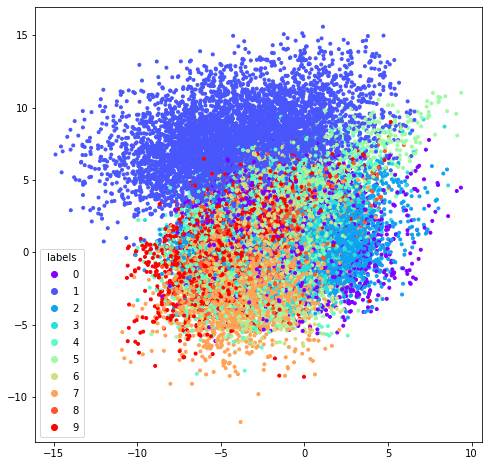

In [13]:
enc = tf.keras.Model(inputs=[img, con_2d], outputs=z)
z = enc([train_images_3d, cons_2d])

# 잠재 벡터 z를 시각화
plt.figure(figsize=(8,8))
scat = plt.scatter(z[:,0], z[:,1], marker='.', c=train_labels, cmap='rainbow')
plt.legend(*scat.legend_elements(), loc="lower left", title='labels')
plt.show()

In [14]:
# 각 조건에 대한 평균을 구하여 출력
mean_digits = np.zeros((10,n_dim))
for i in range(10):
  digit = find_label(train_labels, i)
  mean_digits[i][:] = find_mean(z, digit)
  print('label', i, '\'s mean :', mean_digits[i])
  print()

label 0 's mean : [-1.35189509  1.1733377 ]

label 1 's mean : [-3.72108746  7.25468397]

label 2 's mean : [0.00972956 1.2146349 ]

label 3 's mean : [-0.61776698  1.12460744]

label 4 's mean : [-2.35421276  1.53083098]

label 5 's mean : [-0.86304247  1.6120491 ]

label 6 's mean : [-2.1987474   1.58346093]

label 7 's mean : [-2.62684178 -0.8793453 ]

label 8 's mean : [-1.90113533  1.28627598]

label 9 's mean : [-2.95452142  1.36882699]



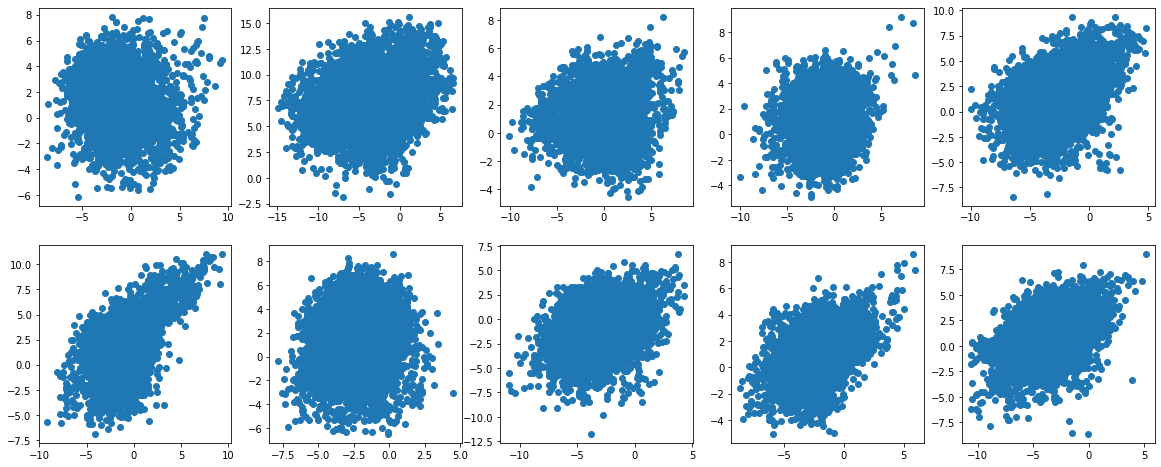

In [15]:
# 각 조건별로 분포 시각화
plt.figure(figsize=(20,8))
for i in range(10):
  digit = find_label(train_labels, i)
  arr = tf.gather(z, digit)
  plt.subplot(2,5,i+1)
  plt.scatter(arr[:,0], arr[:,1])

In [0]:
## input layer (special purposes for conditional generative model)
z_sample = layers.Input(shape=(n_dim,))

## conditional generative model
z_cond = tf.keras.layers.concatenate([z_sample, con])
x_dec = dec_dense_1(z_cond)
x_dec = dec_reshape_1(x_dec)
x_dec = dec_inverse_conv2d_1(x_dec)
x_dec = dec_inverse_conv2d_2(x_dec)
y_dec_pred = dec_reshape_2(x_dec)

cond_decoder = models.Model([z_sample, con], y_dec_pred)

In [18]:
## 디코더의 테스트 입력 설정
import ipywidgets as widgets

con=widgets.FloatSlider(min=0, max=9, step=1)  # 조건 입력을 위한 Slider / 0부터 9까지 1단위로 이동
u=widgets.FloatSlider(min=-5.0, max=5.0)
v=widgets.FloatSlider(min=-5.0, max=5.0)

ui_con = widgets.HBox([con])
ui = widgets.HBox([u,v])

def z_test(con,u, v):
  z_test = np.array([[u,v]])  
  c_test = np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])
  c_test[0][int(con)] = 1.0  # 슬라이더로 선택한 인덱스의 조건을 1로 설정
  print(z_test)

  img_gen = cond_decoder([z_test, c_test])
  plt.imshow(img_gen[0])
  plt.show()  

out = widgets.interactive_output(z_test,  {'con':con, 'u': u, 'v': v})

display(ui_con, ui, out)

Output()

위에서 각 조건별로 평균을 구해보니 조건 '1'만 약 [-4, 7] 정도로 조금 떨어져 있고
다른 조건들은 [-1, 1]에서 가까운 값임을 확인할 수 있었다.

실제로 z를 나타내는 두 개의 슬라이더를 0.00에 두고 왼쪽의 조건 슬라이더만 이동시켰을 때 0부터 9까지 모든 숫자를 잘 구성했지만 1이 가장 흐릿함을 확인할 수 있었다.

또한, 위 산점도를 바탕으로 조건과 두 개의 슬라이더(각각 x축과 y축)을 조절하면 원하는 숫자 이미지를 얻을 수 있었다.




---
한편, 오토인코더와 마찬가지로 z의 각 차원에 각기 다른 특징이 담겨있음을 알 수 있었다.

예를 들면, 조건을 6으로 설정하고 왼쪽 슬라이더(첫 번째 차원)를 좌우로 움직여보면

오른쪽으로 갈수록 숫자가 얇아지고 왼쪽으로 갈수록 두꺼워지는 모습을 볼 수 있었다.

두 번째 슬라이더(오른쪽 차원)도 같은 방식으로 해보면 이미지를 그래프처럼 4분할 해보았을때

슬라이더를 오른쪽으로 옮길수록 숫자 6을 쓰는 시작점이 1사분면에 위치했지만 

슬라이더가 왼쪽으로 갈수록 2사분면에서 숫자 6이 시작해 가장 왼쪽에서는 숫자 6이 누운 모양이 되었다.

다른 숫자들로 바꿔가며 두 슬라이더를 움직여본 결과 모든 숫자에서 비슷한 경향을 발견할 수 있었다.


---



따라서 z의 첫 번째 차원은 숫자의 너비와 관련된 특징을, 두 번째 차원은 숫자가 쓰여진 위치와 방향과 관련된 특징을 학습했음을 알 수 있었다.


